In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import scipy as sp

# отключим вывод варнингов
import warnings
warnings.filterwarnings('ignore')

stud_math = pd.read_csv('stud_math.csv')

In [2]:
display(stud_math.head(10))
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,...,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,...,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,...,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,...,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,...,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,...,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,...,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,...,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,...,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,...,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## Предобработка

In [3]:
# Построение boxplot зависимости целевого значения от указанного как аргумент
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y='score',
                data=stud_math.loc[stud_math.loc[:, column].isin(
                    stud_math.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

    # Построение boxplot зависимости одного параметра значения от другого. Оба передаются как аргументы


def get_boxplot2(column, key):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y=key,
                data=stud_math.loc[stud_math.loc[:, column].isin(
                    stud_math.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

    # Первичный анализ номинативных показателей: построение boxplot; подсчет значений NAN


def analysis_cat_features(column):
    get_boxplot(column)
    s = pd.DataFrame(stud_math.loc[:, column].value_counts())
    print(s)
    print('Значений NAN:', stud_math.loc[:, column].isna().sum())
    total_num = s.loc[:, column].sum() + stud_math.loc[:, column].isna().sum()
    print('Всего значений', total_num)


def num_to_cat(column):
    stud_math.loc[:, column] = stud_math.loc[:, column].apply(int)
    stud_math.loc[:, column] = stud_math.loc[:, column].astype(str)


def fill_none_median(column):
    median_col = stud_math.loc[:, column].median()
    stud_math.loc[:, column] = stud_math.loc[:, column].fillna(median_col)


def fill_none_mode(column):
    mode_col = stud_math.loc[:, column].mode()
    stud_math.loc[:, column] = stud_math.loc[:, column].fillna(mode_col[0])


def get_stat_dif(column):
    cols = stud_math.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud_math.loc[stud_math.loc[:, column] == comb[0], 'score'],
                     stud_math.loc[stud_math.loc[:, column] == comb[1], 'score']).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break


# Список числовых параметров
num_col = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures',
           'studytime, granular', 'famrel', 'freetime', 'goout', 'health', 'absences']

# Список номинативных (категориальных) параметров
cat_col = ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup',
           'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']

# Список нумерованных категориальных параметров
num_as_cat_col = ['Medu', 'Fedu', 'traveltime', 'studytime',
                  'failures', 'famrel', 'freetime', 'goout', 'health']

## Первичный анализ данных в столбцах.

## Анализ числовых параметров

##### Из визуального анализа и описания колонок мы видим, что к послностью числовым числовым параметрам мы можем отнести только целевой показатель score, absence, и отчасти возраст (age).
##### Начнем с конца, проанализируем целевой показатель score.

## score —
##### баллы по госэкзамену по математике

In [4]:
pd.DataFrame(stud_math.score.value_counts())

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
70.0,27
45.0,27
80.0,16


In [5]:
print('Значений NAN:', stud_math.score.isna().sum())

Значений NAN: 6


##### В целевом показателе 6 неопределенных значений. Поскольку показатель целевой, восстанавливать их не будем. Удалим.

In [6]:
stud_math = stud_math.dropna(subset=['score'])

## age —
##### возраст ученика (от 15 до 22)

In [7]:
pd.DataFrame(stud_math.age.value_counts())

,age
16,103
17,98
15,82
18,80
19,21
20,3
22,1
21,1


count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

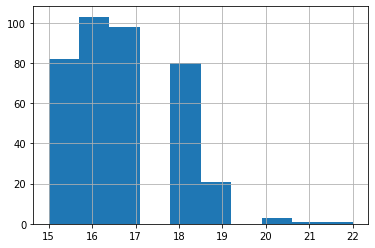

In [8]:
stud_math.age.hist()
stud_math.age.describe()

In [9]:
print('Значений NAN:', stud_math.age.isna().sum())

Значений NAN: 0


##### Вывод: пропущенных значений нет. Есть два редких значения (21, 22),которые выглядят как выбросы, но теоретически, такой возраст, вероятно, возможен. - Оставляем.

## absences —
##### количество пропущенных занятий

In [10]:
pd.DataFrame(stud_math.absences.value_counts())

,absences
0.0,110
2.0,60
4.0,52
6.0,30
8.0,20
10.0,17
12.0,12
14.0,12
3.0,7
16.0,7


In [11]:
print('Значений NAN:', stud_math.age.isna().sum())

Значений NAN: 0


count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

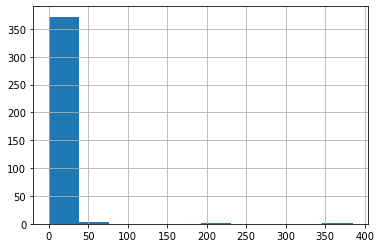

In [12]:
stud_math.absences.hist()
stud_math.absences.describe()

##### Выводы: В целом, видим, что с посещаемостью у выбранных учеников было неплохо. Трудно сказать есть ли выбросы (например, значения 385 и 212), так как не понятно за какой период зафиксированы пропущенные занятия. Но, для данного упражнения, предположим, что выбросы. Заменим на медиану.

In [13]:
stud_math.loc[(stud_math['absences'] > 100),
              'absences'] = stud_math.absences.median()

##### Определим пустые значения в числовых параметрах

In [14]:
for col in num_col:
    print('Значений NAN:', stud_math.loc[:, col].isna().sum(), col)

Значений NAN: 0 age
Значений NAN: 3 Medu
Значений NAN: 24 Fedu
Значений NAN: 28 traveltime
Значений NAN: 7 studytime
Значений NAN: 22 failures
Значений NAN: 7 studytime, granular
Значений NAN: 27 famrel
Значений NAN: 9 freetime
Значений NAN: 7 goout
Значений NAN: 15 health
Значений NAN: 11 absences


##### Все неопределенные значения (NaN) заполняем медианой.

In [15]:
for col in num_col:
    fill_none_median(col)

##### Посмотрим на встречающиеся значения

In [16]:
for col in num_col:
    display(pd.DataFrame(stud_math.loc[:, col].value_counts()))

,age
16,103
17,98
15,82
18,80
19,21
20,3
22,1
21,1


,Medu
4.0,131
2.0,100
3.0,99
1.0,56
0.0,3


,Fedu
3.0,118
2.0,105
4.0,88
1.0,75
0.0,2
40.0,1


,traveltime
1.0,267
2.0,94
3.0,21
4.0,7


,studytime
2.0,196
1.0,103
3.0,63
4.0,27


,failures
0.0,312
1.0,48
2.0,15
3.0,14


,"studytime, granular"
-6.0,196
-3.0,103
-9.0,63
-12.0,27


,famrel
4.0,205
5.0,97
3.0,62
2.0,17
1.0,7
-1.0,1


,freetime
3.0,161
4.0,110
2.0,63
5.0,37
1.0,18


,goout
3.0,133
2.0,101
4.0,81
5.0,51
1.0,23


,health
5.0,137
3.0,88
4.0,75
1.0,47
2.0,42


,absences
0.0,110
4.0,65
2.0,60
6.0,30
8.0,20
10.0,17
14.0,12
12.0,12
3.0,7
16.0,7


#### Кроме score, age и absences, остальные столбцы являются по сути нумерованным категориями, с определенным доменом значений, поэтому анализ на выбросы проводить не имеет смысла. Можно определить значения выпадающие из описанных доменов.

##### В колонке Fedu выбивается значение 40. Предположим, что это ошибочно введенное значение 4. Заменим его.

In [17]:
stud_math.loc[(stud_math['Fedu'] == 40), 'Fedu'] = 4

##### В колонке famrel встречается неспецифицированное значение  -1 (должно быть от 1 до 5). Предположим, что это ошибочная 1 и заменим его.

In [18]:
stud_math.loc[(stud_math['famrel'] == -1, 'famrel')] = 1

##### Построим матрицу корреляций

In [19]:
stud_math.corr()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
age,1.000000,-0.146405,-0.150142,0.076013,-0.018019,0.206279,0.018019,0.056941,0.013994,0.121057,-0.065719,0.167024,-0.155726
Medu,-0.146405,1.000000,0.602619,-0.152597,0.079513,-0.239668,-0.079513,-0.003566,0.037699,0.071235,-0.054431,0.096321,0.209758
Fedu,-0.150142,0.602619,1.000000,-0.127860,0.020823,-0.259146,-0.020823,-0.017128,-0.008456,0.050380,0.017967,0.035995,0.124559
traveltime,0.076013,-0.152597,-0.127860,1.000000,-0.098226,0.035113,0.098226,-0.029213,-0.016696,0.046390,-0.035852,0.000573,-0.056535
studytime,-0.018019,0.079513,0.020823,-0.098226,1.000000,-0.169399,-1.000000,0.037950,-0.122057,-0.053554,-0.072790,-0.064045,0.114295
failures,0.206279,-0.239668,-0.259146,0.035113,-0.169399,1.000000,0.169399,-0.028517,0.087558,0.101036,0.082165,0.060360,-0.337187
"studytime, granular",0.018019,-0.079513,-0.020823,0.098226,-1.000000,0.169399,1.000000,-0.037950,0.122057,0.053554,0.072790,0.064045,-0.114295
famrel,0.056941,-0.003566,-0.017128,-0.029213,0.037950,-0.028517,-0.037950,1.000000,0.164830,0.069514,0.088845,-0.041409,0.052902
freetime,0.013994,0.037699,-0.008456,-0.016696,-0.122057,0.087558,0.122057,0.164830,1.000000,0.294450,0.063718,-0.070327,0.017481
goout,0.121057,0.071235,0.050380,0.046390,-0.053554,0.101036,0.053554,0.069514,0.294450,1.000000,-0.016427,0.035627,-0.127742


###### Заметим, что столбца "studytime, granular" нет в описании. При этом, видна полная корреляция между столбцами "studytime, granular" и "studytime". Судя по всему, его можно безболезненно удалить.

In [20]:
stud_math = stud_math.drop(['studytime, granular'], axis=1)

##### По матрице корелляций параметры age и absence очень слабо кореллируют с целевым показателем. Можем их также удалить.

In [21]:
stud_math = stud_math.drop(['age', 'absences'], axis=1)

##### В оставшихся параметрах попробуем заменить нумерацию на категории и проанализировать эти столбцы как номинативные переменные

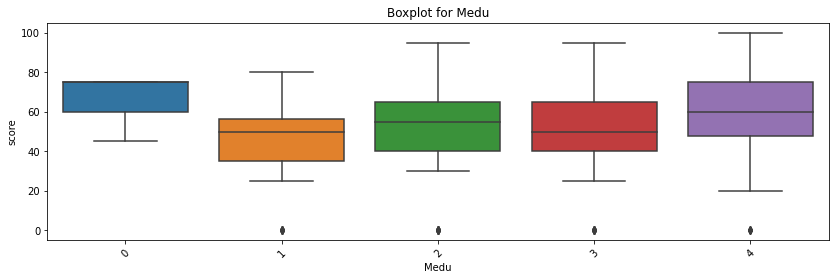

   Medu
4   131
2   100
3    99
1    56
0     3
Значений NAN: 0
Всего значений 389


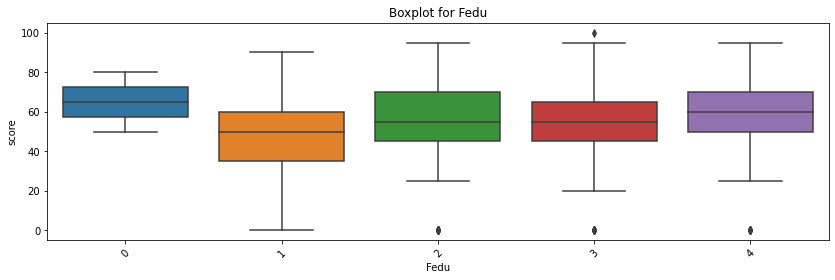

   Fedu
3   118
2   105
4    89
1    75
0     2
Значений NAN: 0
Всего значений 389


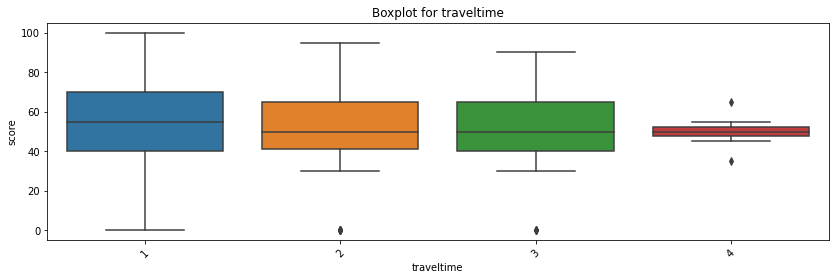

   traveltime
1         267
2          94
3          21
4           7
Значений NAN: 0
Всего значений 389


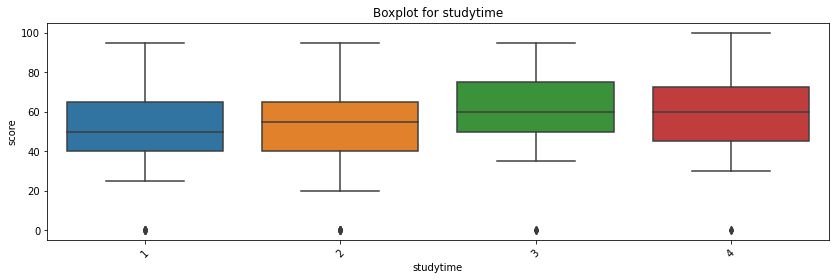

   studytime
2        196
1        103
3         63
4         27
Значений NAN: 0
Всего значений 389


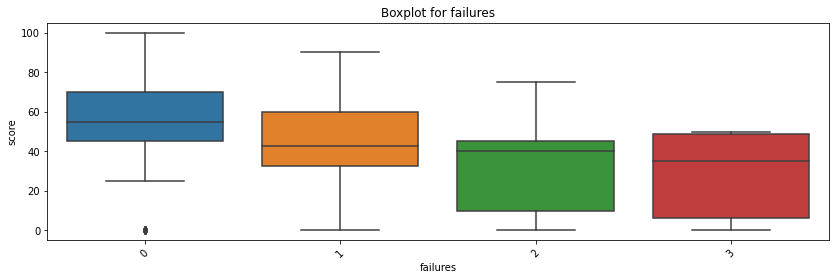

   failures
0       312
1        48
2        15
3        14
Значений NAN: 0
Всего значений 389


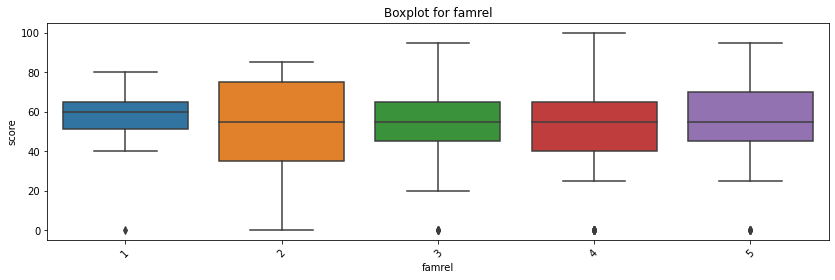

   famrel
4     205
5      97
3      62
2      17
1       8
Значений NAN: 0
Всего значений 389


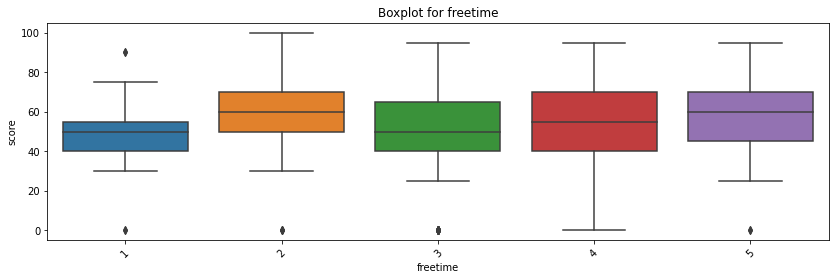

   freetime
3       161
4       110
2        63
5        37
1        18
Значений NAN: 0
Всего значений 389


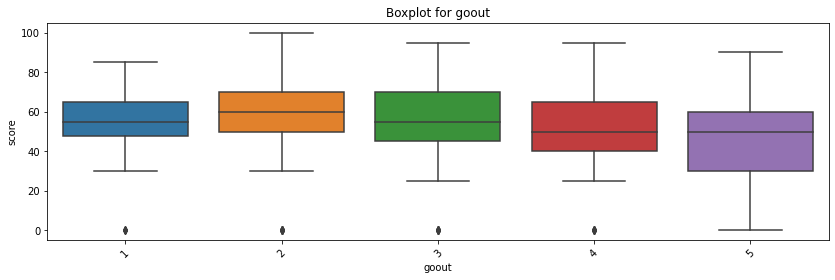

   goout
3    133
2    101
4     81
5     51
1     23
Значений NAN: 0
Всего значений 389


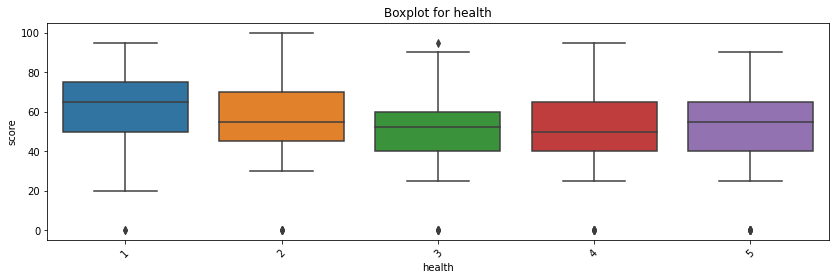

   health
5     137
3      88
4      75
1      47
2      42
Значений NAN: 0
Всего значений 389


In [22]:
for col in num_as_cat_col:
    num_to_cat(col)
    analysis_cat_features(col)

##### На боксплотах эти параметры выглядят значимыми (что-то сильнее, что-то слабее) кроме, пожалуй, traveltime и famrel

##### Переменные freetime, studytime, goout и health выглядят слабо значимыми для целевого показателя. Их сохранение под вопросом.

##### Попробуем применить тест Стьюдента для этих же переменных.

In [23]:
for col in num_as_cat_col:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Medu
Найдены статистически значимые различия для колонки failures


##### По тесту Стьюдента, статистически значимых различий в этой группе параметры Medu и failures. Однако, поскольку на боксплотах также заметна разница Fedu по целевому показателю, предлагаю вкючить его в дальнейшую модель. Т.о. из этой группы у нас три значимых показателя Medu Fedu и failures. Их оставляем.
##### Переменные freetime, studytime, goout и health слабозначимые. Однако по боксплотам некоторое влияние все же есть. Возможно, имеет смысл оставить для проверки и настройки модели.
##### Таким образом, удаляем traveltime и famrel.

In [24]:
stud_math = stud_math.drop(['traveltime', 'famrel'], axis=1)

In [25]:
#stud_math = stud_math.drop(['studytime', 'goout', 'health', 'freetime'], axis = 1)

## Анализ номинативных параметров

##### Проанализируем сразу все номинативные параметры и построим боксплоты

##### Перед этим все неопределенные значения (NaN) заполняем модой.

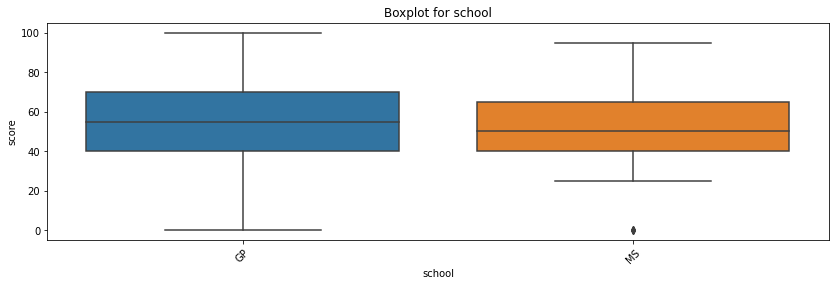

    school
GP     344
MS      45
Значений NAN: 0
Всего значений 389


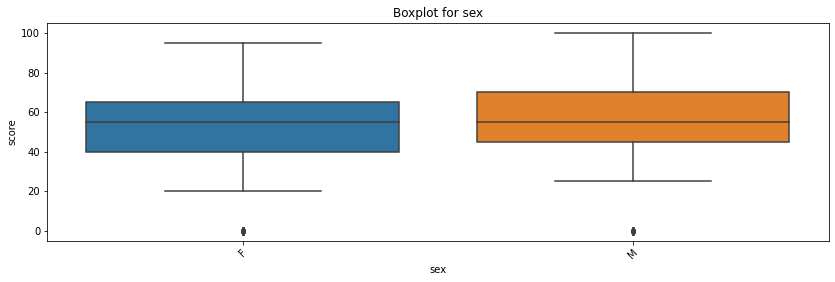

   sex
F  204
M  185
Значений NAN: 0
Всего значений 389


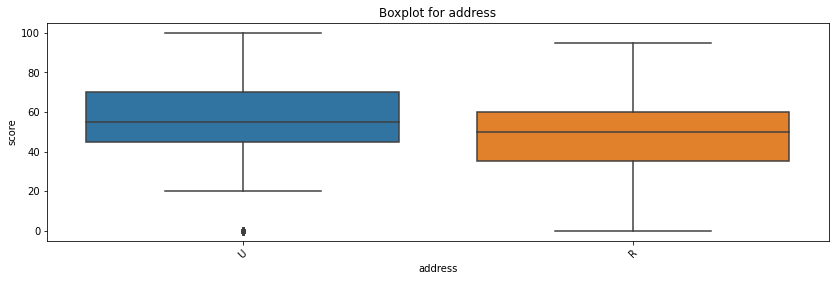

   address
U      306
R       83
Значений NAN: 0
Всего значений 389


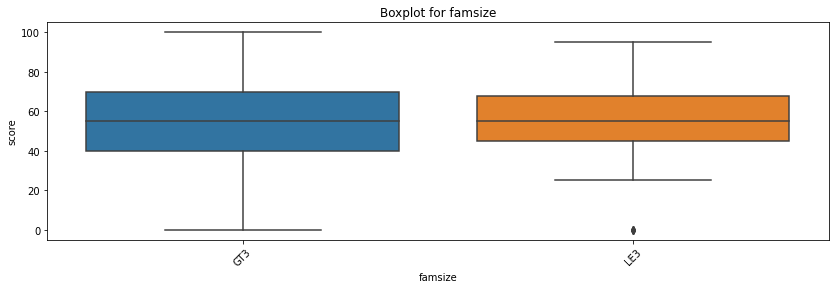

     famsize
GT3      282
LE3      107
Значений NAN: 0
Всего значений 389


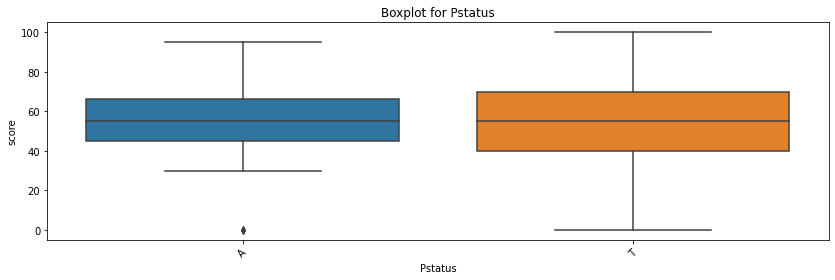

   Pstatus
T      353
A       36
Значений NAN: 0
Всего значений 389


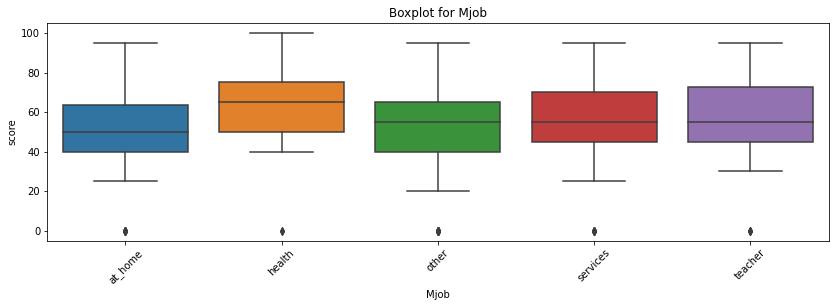

          Mjob
other      146
services    98
at_home     58
teacher     55
health      32
Значений NAN: 0
Всего значений 389


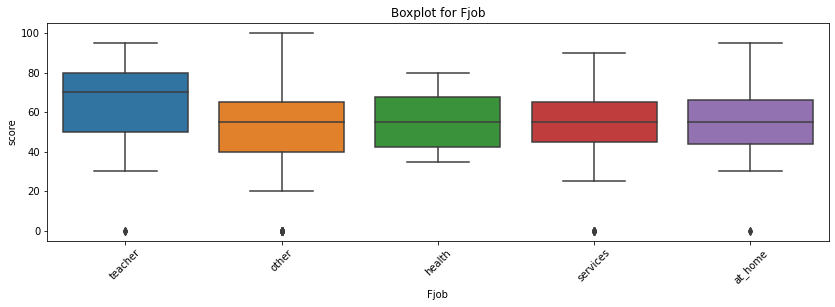

          Fjob
other      230
services    99
teacher     29
at_home     16
health      15
Значений NAN: 0
Всего значений 389


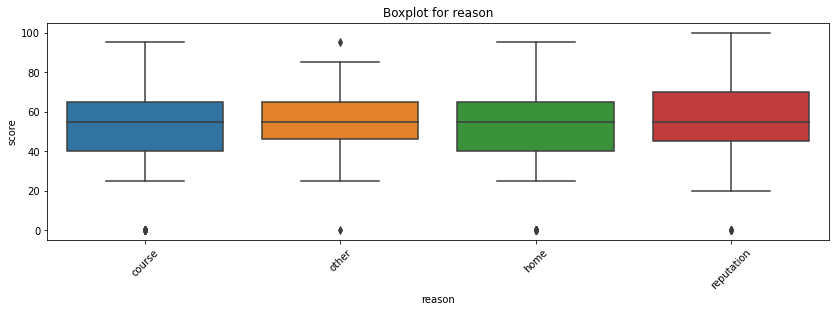

            reason
course         152
reputation     102
home           101
other           34
Значений NAN: 0
Всего значений 389


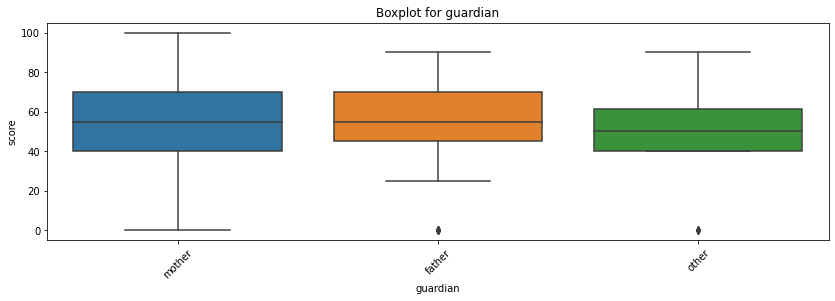

        guardian
mother       279
father        86
other         24
Значений NAN: 0
Всего значений 389


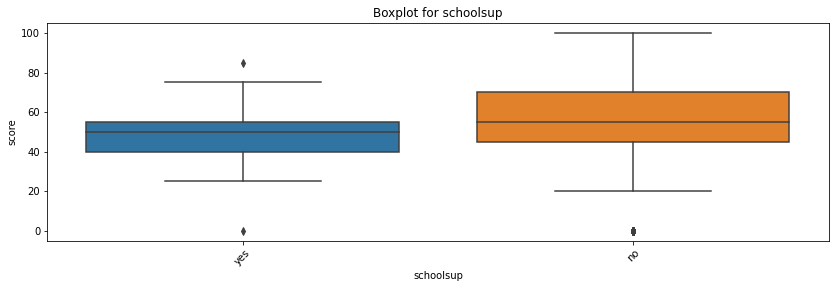

     schoolsup
no         340
yes         49
Значений NAN: 0
Всего значений 389


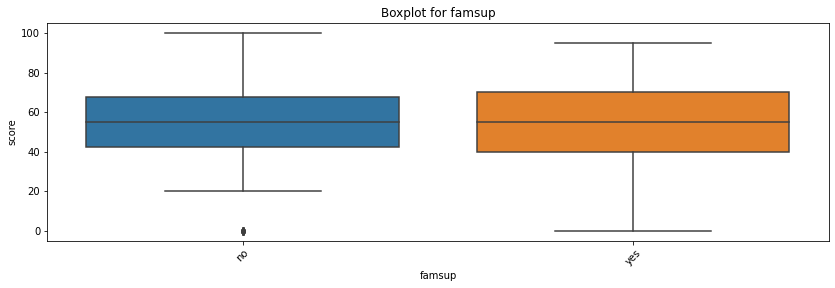

     famsup
yes     254
no      135
Значений NAN: 0
Всего значений 389


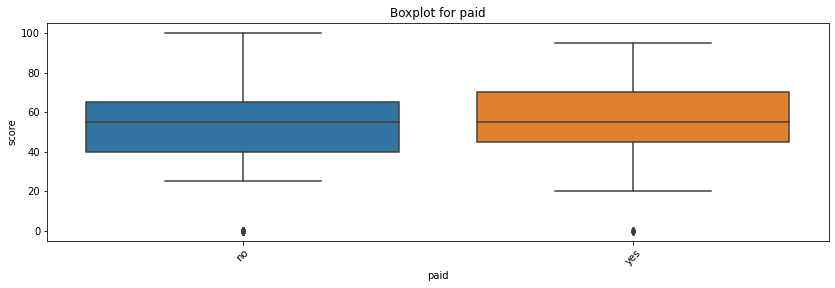

     paid
no    236
yes   153
Значений NAN: 0
Всего значений 389


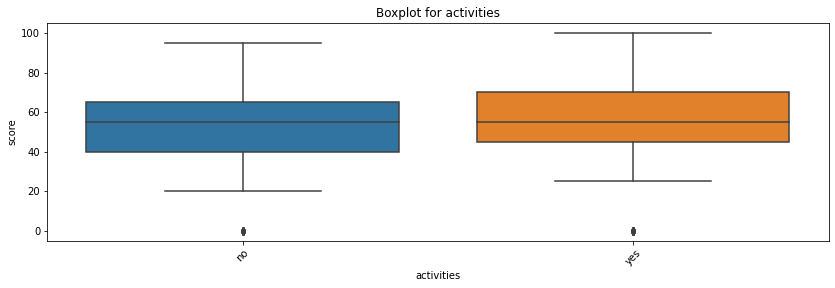

     activities
yes         206
no          183
Значений NAN: 0
Всего значений 389


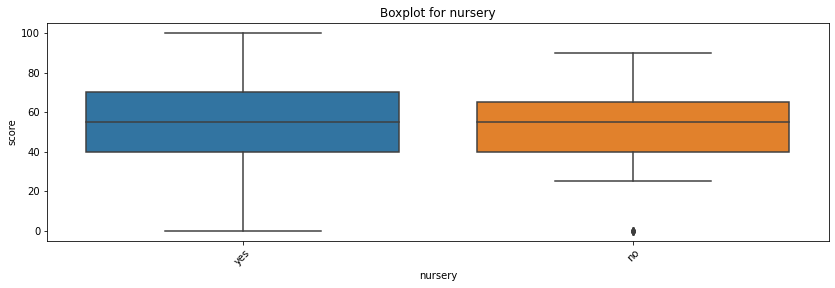

     nursery
yes      312
no        77
Значений NAN: 0
Всего значений 389


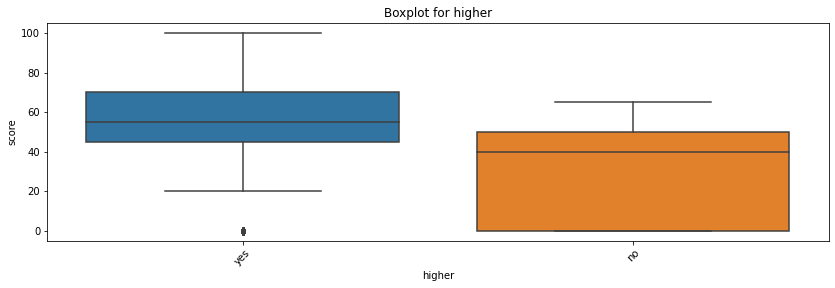

     higher
yes     370
no       19
Значений NAN: 0
Всего значений 389


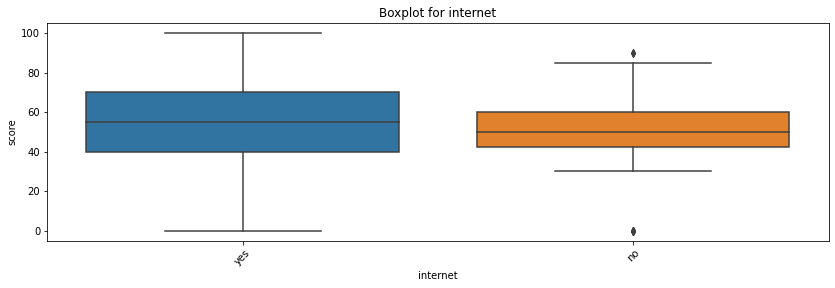

     internet
yes       334
no         55
Значений NAN: 0
Всего значений 389


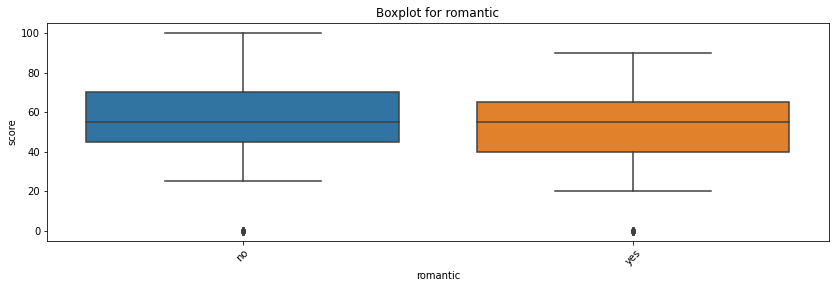

     romantic
no        266
yes       123
Значений NAN: 0
Всего значений 389


In [26]:
for col in cat_col:
    fill_none_mode(col)
    analysis_cat_features(col)

##### Применяем тест Стьюдента

In [27]:
for col in cat_col:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


##### тест Стьюдента дал значимые различия для параметров address, Mjob, higher и romantic. Для параметра Fjob по тесту, статистически значимые различия не выявлены, но по боксплотам признак достаточно значимый - предлагаю его также включить в модель. Остальные удаляем.

##### При этом, параметры romantic и address не выглядят значимыми на боксплотах. Хорошо бы проверить их поведение на модели, но поскольку эта часть в задачу не входит, для в данного упражнения , предлагаю их также удалить.

In [28]:
stud_math = stud_math.drop(['address', 'school', 'sex', 'famsize', 'Pstatus', 'reason', 'guardian',
                            'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'internet', 'romantic'], axis=1)

### Должны остаться для модели: Medu, Fedu, Mjob, Fjob, studytime, failures, higher, freetime, goout и health

In [29]:
# Проверяем
stud_math

,Medu,Fedu,Mjob,Fjob,studytime,failures,higher,freetime,goout,health,score
0,4,4,at_home,teacher,2,0,yes,3,4,3,30.0
1,1,1,at_home,other,2,0,yes,3,3,3,30.0
2,1,1,at_home,other,2,3,yes,3,2,3,50.0
3,4,2,health,other,3,0,yes,2,2,5,75.0
4,3,3,other,other,2,0,yes,3,2,5,50.0
...,...,...,...,...,...,...,...,...,...,...,...
390,2,2,services,services,2,2,yes,5,4,4,45.0
391,3,1,services,services,1,0,yes,4,5,2,80.0
392,1,1,other,other,1,3,yes,5,3,3,35.0
393,3,2,services,other,1,0,yes,4,1,5,50.0


## Выводы:
##### Данные довольно чистые. Неопределенных значений немного. В среднем, порядка 10%. Выбросов практически нет.

##### Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это Medu, Fedu, Mjob, Fjob, failures, higher.

##### Параметры studytime, freetime, goout и health, рекомендуется также добавить в модель для проверки, как показавшие некоторую значимость на боксплотах.

##### Параметры address и romantic были определены как имеющие статистически значимые различия по тесту Стьюдента, но распределение на боксплотах показало их слабое влияние на целевой параметр. Эти переменные также могли бы быть использованы для проверки на модели, но для данной задачи было решено удалить.